#Importing all libraries, google disk for loading dataset


In [1]:
!pip install optuna
import optuna
import torch
import numpy as np
from torchvision import transforms, datasets
import os
from tqdm import tqdm_notebook
import torchvision
from torch import nn
from torch.utils.data import Dataset, ConcatDataset, SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, models
from torch.optim import lr_scheduler

from optuna.trial import TrialState
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(69)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# # device = torch.device("cpu")
# device
# device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#Different augmentations and transformations, loading dataset


In [4]:

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

transform2 = transforms.Compose(

    [
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
    ]
)

transformImageNet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformResNet152 = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformGoogle = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [5]:
import os
from torchvision import transforms
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None, fake_label=0, real_label=1):
        self.folder_path = folder_path
        self.image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if
                            img.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        self.transform = transform
        self.fake_label = fake_label
        self.real_label = real_label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Assign labels based on folder path
        if "fake" in self.folder_path:
            label = self.fake_label
        else:
            label = self.real_label

        return image, label



In [6]:
training_folder = '/content/drive/MyDrive/project DeepFakes/data/training'

trainset = datasets.ImageFolder(root=training_folder, transform=transform2)
# fake_aug = CustomDataset('/content/drive/MyDrive/project DeepFakes/data/training/fake', transform=transform)
# real_aug = CustomDataset('/content/drive/MyDrive/project DeepFakes/data/training/real', transform=transform)
# combined_dataset = ConcatDataset([trainset, fake_aug, real_aug])

# total_samples = len(combined_dataset)
# num_samples = int(0.8 * total_samples)

# sampler = SubsetRandomSampler(torch.randperm(total_samples)[:num_samples])

# trainloader = DataLoader(combined_dataset, batch_size=16, sampler=sampler)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

test_folder = '/content/drive/MyDrive/project DeepFakes/data/validation'
testset = datasets.ImageFolder(root=test_folder, transform=transform2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

In [7]:
for images, labels in trainloader:
    print("Batch Shape:", images)
    print("Labels Shape:", labels)
    break
# print(trainloader.dataset.cummulative_sizes)

Batch Shape: tensor([[[[0.6392, 0.6588, 0.6824,  ..., 0.7176, 0.6902, 0.6824],
          [0.6667, 0.6706, 0.6902,  ..., 0.7020, 0.6784, 0.6588],
          [0.6745, 0.6667, 0.6784,  ..., 0.7020, 0.6902, 0.6745],
          ...,
          [0.2000, 0.1647, 0.0471,  ..., 0.0157, 0.0235, 0.0667],
          [0.1373, 0.0941, 0.0157,  ..., 0.0196, 0.0118, 0.0235],
          [0.0510, 0.0000, 0.0196,  ..., 0.0196, 0.0275, 0.0431]],

         [[0.8196, 0.8392, 0.8549,  ..., 0.9176, 0.8902, 0.8824],
          [0.8471, 0.8510, 0.8627,  ..., 0.9020, 0.8784, 0.8588],
          [0.8549, 0.8392, 0.8510,  ..., 0.9020, 0.8902, 0.8745],
          ...,
          [0.3137, 0.2784, 0.1412,  ..., 0.1294, 0.1647, 0.1961],
          [0.2745, 0.2235, 0.1255,  ..., 0.1176, 0.1373, 0.1412],
          [0.2000, 0.1333, 0.1373,  ..., 0.1020, 0.1294, 0.1529]],

         [[0.7098, 0.7294, 0.7490,  ..., 0.8431, 0.8157, 0.8078],
          [0.7373, 0.7412, 0.7569,  ..., 0.8275, 0.8039, 0.7843],
          [0.7451, 0.7333, 0.

#First Model with parameters that were get from optuna

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=3, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=3, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=3, padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        # self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(17 * 17 * 64, 1000)
        self.fc2 = nn.Linear(1000, 1)
        #self.fc3 = nn.Linear(30, 1)
        #self.fc2_2 = nn.Linear(1000, 1)

    def forward(self, x):
        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        #print(x.shape)
        x = x.view(-1, 17 * 17 * 64)
        # x = self.dropout(x)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [18]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()

#         # Initial layers are the same
#         self.conv1 = nn.Conv2d(3, 32, 5, 3, 2)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, 5, 3, 2)
#         self.bn2 = nn.BatchNorm2d(64)

#         # Additional layers
#         self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
#         self.bn4 = nn.BatchNorm2d(128)

#         # Adapt the linear layer to the new size
#         self.fc1 = nn.Linear(67 * 67 * 128, 1000)
#         self.fc2 = nn.Linear(1000, 1)

#     def forward(self, x):
#         # Original layers with skip connections
#         out = self.bn1(F.relu(self.conv1(x)))
#         out = self.bn2(F.relu(self.conv2(out)))

#         # Additional layers
#         out = self.bn3(F.relu(self.conv3(out)))
#         out = self.bn4(F.relu(self.conv4(out)))
#         #print(out.shape)
#         out = out.view(-1, 67 * 67 * 128)
#         out = F.relu(self.fc1(out))
#         out = torch.sigmoid(self.fc2(out))  # Use torch.sigmoid instead of F.sigmoid (which is deprecated)

#         return out

In [16]:
batch = []
net = ConvNet().to(device)

batch = next(iter(trainloader))

net.forward(torch.FloatTensor(batch[0]).to(device))

torch.Size([16, 128, 67, 67])


RuntimeError: shape '[-1, 36992]' is invalid for input of size 9193472

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()

learning_rate = 0.00010246617213508516  #for adam
#learning_rate = 1.71903735673968e-05 #for RMS

optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = torch.optim.RMSprop(net.parameters(), lr = learning_rate)
losses = []

<ipython-input-13-9aa3a5ed72ca>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-13-9aa3a5ed72ca>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/116 [00:00<?, ?it/s]

KeyboardInterrupt: 

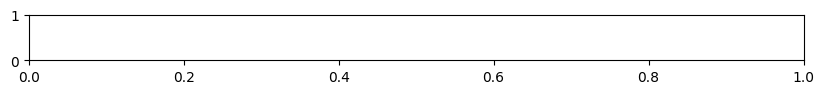

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(10, 1, 1)

for epoch in tqdm_notebook(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):

        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.float()

        optimizer.zero_grad()

        y_pred = net(X_batch)

        loss = loss_fn(y_pred, y_batch.unsqueeze(1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            losses.append(running_loss / 50)
            running_loss = 0.0
ax.plot(np.arange(len(losses)), losses)
plt.show()

In [ ]:
class_correct = [0, 0]
class_total = [0, 0]
classes = ['Real', 'Fake']
net.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)

        y_pred = net(images)

        predicted = torch.squeeze(torch.round(y_pred))

        c = predicted.cpu().detach() == labels

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

    for i in range(2):
        print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))
    print(class_total)
    print(class_correct)
    print('Total Accuracy is: ', sum(class_correct) / sum(class_total))

KeyboardInterrupt: 

#Optuna model for searching best number of layers and neurons in them

In [37]:
class OptunaModel(nn.Module):
    def __init__(self, input_size, output_size, num_conv_layers, trial):

        super(OptunaModel, self).__init__()

        in_channels = input_size
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            num_neurons = trial.suggest_int(f'num_neurons_layer_{_}', 128 // (1.5 ** i), 512 // (1.5 ** i))
            self.conv_layers.append(nn.Conv2d(input_size, num_neurons, kernel_size=5, stride=3, padding=2))
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            in_channels = num_neurons

        self.flatten = nn.Flatten()
        self.l_layers = nn.ModuleList()

        self.output_layer = nn.Linear(in_channels, output_size)
        self.sigmoid = nn.Sigmoid()

        for i in range(2):
            num_neurons = trial.suggest_int(f'num_neurons_l_{i}', 64 // (1.5 ** i), 512 // (1.5 ** i))
            self.l_layers.append(nn.Linear(input_size, num_neurons))
            self.l_layers.append(nn.ReLU())
            in_channels = num_neurons

        self.output_layer = nn.Linear(in_channels, output_size)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = self.flatten(x)

        for layer in self.l_layers:
            x = layer(x)

        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x


def objective(trial):
    input_size = 3
    output_size = 1
    num_conv_layers = trial.suggest_int('num_layers', 2, 5)
    model = OptunaModel(input_size, output_size, num_conv_layers, trial).to(device)

    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in tqdm_notebook(range(10)):

        running_loss = 0.0
        for i, batch in enumerate(tqdm_notebook(trainloader)):

            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.float()

            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                losses.append(running_loss)
                running_loss = 0.0

    class_correct = [0, 0]
    class_total = [0, 0]
    classes = ['Real', 'Fake']

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)

            y_pred = model(images)

            predicted = torch.squeeze(torch.round(y_pred))

            c = predicted.cpu().detach() == labels

            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    return sum(class_correct) / sum(class_total)



In [38]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

best_trial = study.best_trial
best_trial.value

[I 2024-01-15 11:37:45,433] A new study created in memory with name: no-name-e6614e0e-eac5-4e88-a251-e6945e2a2dc5
<ipython-input-37-525a48656f29>:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-37-525a48656f29>:60: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/116 [00:00<?, ?it/s]

[W 2024-01-15 11:37:58,840] Trial 0 failed with parameters: {'num_layers': 2, 'num_neurons_layer_<torch._C.Generator object at 0x7ac2c8ac95f0>': 428, 'num_neurons_l_0': 115, 'num_neurons_l_1': 173} because of the following error: RuntimeError('Given groups=1, weight of size [428, 3, 5, 5], expected input[16, 428, 100, 100] to have 3 channels, but got 428 channels instead').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-37-525a48656f29>", line 68, in objective
    y_pred = model(X_batch)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-37-525a48656f29>", line 36, in forward
   

RuntimeError: Given groups=1, weight of size [428, 3, 5, 5], expected input[16, 428, 100, 100] to have 3 channels, but got 428 channels instead

In [ ]:
best_trial.params

In [8]:
def train_model(model, loss_fn, optimizer, scheduler=None, num_epochs=10, effnet=False):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(10, 1, 1)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    acc = []

    for epoch in tqdm_notebook(range(num_epochs)):

        if scheduler is not None:
            scheduler.step()
        running_loss = 0.0
        model.train()

        for i, batch in enumerate(tqdm_notebook(trainloader)):

            X_batch, y_batch = batch
            y_batch = y_batch.float()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))

            if not effnet:
                loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 25 == 24:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 25))
                #losses.append(running_loss / 50)
                running_loss = 0.0

        class_correct = [0, 0]
        class_total = [0, 0]
        classes = ['Real', 'Fake']
        model.eval()

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)

                y_pred = model(images)

                predicted = torch.squeeze(torch.round(y_pred))

                c = predicted.cpu().detach() == labels

                for i in range(len(labels)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        # for i in range(2):
        #     print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))
        # print(class_total)
        # print(class_correct)
        print('Total Accuracy is: ', sum(class_correct) / sum(class_total))
        accuracy = sum(class_correct) / sum(class_total)
        acc.append(sum(class_correct) / sum(class_total))
        if accuracy > best_acc and accuracy > 0.72:
            best_acc = accuracy
            best_model_wts = model.state_dict()
            print("New Best Score!!! ")
            torch.save(model.state_dict(),
                       'own_' + str(accuracy) + '_on20epoch_adam(0.0001), batch_size = 16 Imagenet.pth')

    model.load_state_dict(best_model_wts)
    ax.plot(np.arange(len(acc)), acc)
    plt.show()
    return model, acc




<ipython-input-8-1961ef7170dc>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-8-1961ef7170dc>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/116 [00:00<?, ?it/s]

[1,    25] loss: 0.700
[1,    50] loss: 0.695
[1,    75] loss: 0.691
[1,   100] loss: 0.696
Total Accuracy is:  0.51


  0%|          | 0/116 [00:00<?, ?it/s]

[2,    25] loss: 0.685
[2,    50] loss: 0.689
[2,    75] loss: 0.704
[2,   100] loss: 0.684
Total Accuracy is:  0.505


  0%|          | 0/116 [00:00<?, ?it/s]

[3,    25] loss: 0.697
[3,    50] loss: 0.686
[3,    75] loss: 0.687
[3,   100] loss: 0.696
Total Accuracy is:  0.515


  0%|          | 0/116 [00:00<?, ?it/s]

[4,    25] loss: 0.670
[4,    50] loss: 0.685
[4,    75] loss: 0.684
[4,   100] loss: 0.732
Total Accuracy is:  0.53


  0%|          | 0/116 [00:00<?, ?it/s]

[5,    25] loss: 0.699
[5,    50] loss: 0.670
[5,    75] loss: 0.693
[5,   100] loss: 0.693
Total Accuracy is:  0.505


  0%|          | 0/116 [00:00<?, ?it/s]

[6,    25] loss: 0.689
[6,    50] loss: 0.684
[6,    75] loss: 0.676
[6,   100] loss: 0.685
Total Accuracy is:  0.505


  0%|          | 0/116 [00:00<?, ?it/s]

[7,    25] loss: 0.685
[7,    50] loss: 0.687
[7,    75] loss: 0.684
[7,   100] loss: 0.671
Total Accuracy is:  0.52


  0%|          | 0/116 [00:00<?, ?it/s]

[8,    25] loss: 0.680
[8,    50] loss: 0.680
[8,    75] loss: 0.684
[8,   100] loss: 0.673
Total Accuracy is:  0.515


  0%|          | 0/116 [00:00<?, ?it/s]

[9,    25] loss: 0.678
[9,    50] loss: 0.668
[9,    75] loss: 0.680
[9,   100] loss: 0.674
Total Accuracy is:  0.535


  0%|          | 0/116 [00:00<?, ?it/s]

[10,    25] loss: 0.690
[10,    50] loss: 0.675
[10,    75] loss: 0.682
[10,   100] loss: 0.674
Total Accuracy is:  0.52


  0%|          | 0/116 [00:00<?, ?it/s]

[11,    25] loss: 0.686
[11,    50] loss: 0.675


KeyboardInterrupt: 

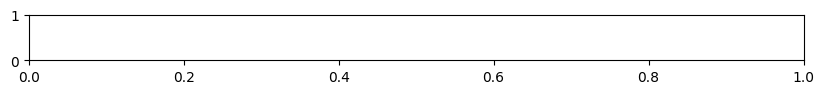

In [19]:
batch = []
net = ConvNet().to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

#learning_rate = 0.00010246617213508516 #for adam
learning_rate = 1.71903735673968e-05  #for RMS

#optimizer = optim.Adam(net.parameters(), lr=learning_rate)

optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
losses = []

net, acc = train_model(net, loss_fn, optimizer, num_epochs=20)

In [ ]:
class_correct = [0, 0]
class_total = [0, 0]
classes = ['Real', 'Fake']

net.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)

        y_pred = net(images)

        predicted = torch.squeeze(torch.round(y_pred))

        c = predicted.cpu().detach() == labels

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))
print(class_total)
print(class_correct)
print(sum(class_correct) / sum(class_total))

Accuracy of  Real : 59 %
Accuracy of  Fake : 67 %
[100, 100]
[59, 67]
0.63


#Part where big models are retrained

In [7]:
effnet = models.efficientnet_b1(pretrained=True)

# for param in model_vgg.features[:-1].parameters():
#     param.requires_grad = False

effnet.classifier[1] = nn.Sequential(
    nn.Linear(1280, 1),
    nn.Sigmoid()
)

# param_groups = [
#     {'params': model_vgg.features.parameters(), 'lr': 0.00001},
#     {'params': model_vgg.classifier.parameters(), 'lr': 0.001}
# ]

effnet = effnet.to(device)

loss_fn2 = torch.nn.BCEWithLogitsLoss()

optimizer = optim.Adam(effnet.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 78.8MB/s]


<ipython-input-8-b7245a8789f7>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-8-b7245a8789f7>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/162 [00:00<?, ?it/s]

KeyboardInterrupt: 

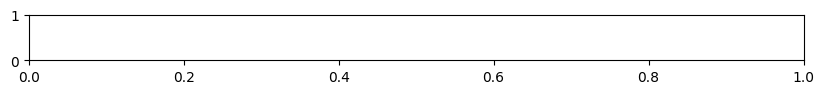

In [ ]:
effnet, acc = train_model(effnet, loss_fn2, optimizer, exp_lr_scheduler, num_epochs=15)

In [ ]:
resnet = models.resnet34(pretrained=True)  #best works without any staff. Straightforward model retraining

print(resnet)
# for param in resnet.parameters():
#     param.requires_grad = False

# for param in resnet.layer4.parameters():
#     param.requires_grad = True
# for param in resnet.layer3.parameters():
#     param.requires_grad = True


resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1),
    nn.Sigmoid()
)

# param_groups = [
#     {'params': resnet.layer1.parameters(), 'lr': 0.000001},
#     {'params': resnet.layer2.parameters(), 'lr': 0.00001},
#     {'params': resnet.layer3.parameters(), 'lr': 0.0001},
#     {'params': resnet.layer4.parameters(), 'lr': 0.001},
#     {'params': resnet.fc.parameters(), 'lr': 0.001}
# ]

resnet = resnet.to(device)

loss_fn2 = torch.nn.BCEWithLogitsLoss()

optimizer3 = optim.Adam(resnet.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer3, step_size=10, gamma=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 163MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<ipython-input-11-b7245a8789f7>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-11-b7245a8789f7>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/116 [00:00<?, ?it/s]

[1,    25] loss: 0.244
[1,    50] loss: 0.252
[1,    75] loss: 0.251
[1,   100] loss: 0.249
Total Accuracy is:  0.76
New Best Score!!! 


  0%|          | 0/116 [00:00<?, ?it/s]

[2,    25] loss: 0.252
[2,    50] loss: 0.262
[2,    75] loss: 0.249
[2,   100] loss: 0.254
Total Accuracy is:  0.725


  0%|          | 0/116 [00:00<?, ?it/s]

[3,    25] loss: 0.261
[3,    50] loss: 0.247
[3,    75] loss: 0.257
[3,   100] loss: 0.249
Total Accuracy is:  0.765
New Best Score!!! 


  0%|          | 0/116 [00:00<?, ?it/s]

[4,    25] loss: 0.260
[4,    50] loss: 0.257
[4,    75] loss: 0.247
[4,   100] loss: 0.247
Total Accuracy is:  0.8
New Best Score!!! 


  0%|          | 0/116 [00:00<?, ?it/s]

[5,    25] loss: 0.252
[5,    50] loss: 0.255
[5,    75] loss: 0.245
[5,   100] loss: 0.247
Total Accuracy is:  0.74


  0%|          | 0/116 [00:00<?, ?it/s]

[6,    25] loss: 0.253
[6,    50] loss: 0.251
[6,    75] loss: 0.248
[6,   100] loss: 0.242
Total Accuracy is:  0.73


  0%|          | 0/116 [00:00<?, ?it/s]

[7,    25] loss: 0.257
[7,    50] loss: 0.253
[7,    75] loss: 0.241
[7,   100] loss: 0.251
Total Accuracy is:  0.72


  0%|          | 0/116 [00:00<?, ?it/s]

[8,    25] loss: 0.248
[8,    50] loss: 0.253
[8,    75] loss: 0.247
[8,   100] loss: 0.248
Total Accuracy is:  0.72


  0%|          | 0/116 [00:00<?, ?it/s]

[9,    25] loss: 0.241
[9,    50] loss: 0.247
[9,    75] loss: 0.252
[9,   100] loss: 0.249
Total Accuracy is:  0.795


  0%|          | 0/116 [00:00<?, ?it/s]

[10,    25] loss: 0.251
[10,    50] loss: 0.246
[10,    75] loss: 0.248
[10,   100] loss: 0.244
Total Accuracy is:  0.76


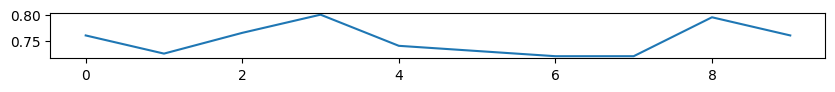

In [ ]:
resnet, acc = train_model(resnet, loss_fn2, optimizer3, exp_lr_scheduler, num_epochs=10)

In [ ]:

class_correct = [0, 0]
class_total = [0, 0]
classes = ['Real', 'Fake']
resnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)

        if len(labels) == 2:
            continue
        y_pred = resnet(images)

        predicted = torch.squeeze(torch.round(y_pred))
        # print(predicted)
        # print(labels)
        c = predicted.cpu().detach() == labels

        #print(labels)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(class_correct, class_total)
print(sum(class_correct) / sum(class_total))


[67, 74] [100, 100]
0.705


In [10]:
gnet = models.googlenet(pretrained=True)

gnet.fc = nn.Sequential(
    nn.Linear(1024, 1, bias=True),
    nn.Sigmoid()
)

# for param in gnet.parameters():
#     param.requires_grad = False

gnet = gnet.to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(gnet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 73.2MB/s]


<ipython-input-8-17f41348d45f>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/15 [00:00<?, ?it/s]

<ipython-input-8-17f41348d45f>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/185 [00:00<?, ?it/s]

[1,    25] loss: 0.351
[1,    50] loss: 0.340
[1,    75] loss: 0.326
[1,   100] loss: 0.328
[1,   125] loss: 0.319
[1,   150] loss: 0.322
[1,   175] loss: 0.305
Total Accuracy is:  0.665


  0%|          | 0/185 [00:00<?, ?it/s]

[2,    25] loss: 0.314
[2,    50] loss: 0.320
[2,    75] loss: 0.307
[2,   100] loss: 0.300
[2,   125] loss: 0.293
[2,   150] loss: 0.295
[2,   175] loss: 0.298
Total Accuracy is:  0.735
New Best Score!!! 


  0%|          | 0/185 [00:00<?, ?it/s]

[3,    25] loss: 0.290
[3,    50] loss: 0.285
[3,    75] loss: 0.283
[3,   100] loss: 0.283
[3,   125] loss: 0.284
[3,   150] loss: 0.277
[3,   175] loss: 0.287
Total Accuracy is:  0.705


  0%|          | 0/185 [00:00<?, ?it/s]

[4,    25] loss: 0.264
[4,    50] loss: 0.274
[4,    75] loss: 0.275
[4,   100] loss: 0.269
[4,   125] loss: 0.284
[4,   150] loss: 0.277
[4,   175] loss: 0.273
Total Accuracy is:  0.76
New Best Score!!! 


  0%|          | 0/185 [00:00<?, ?it/s]

[5,    25] loss: 0.266
[5,    50] loss: 0.258
[5,    75] loss: 0.269
[5,   100] loss: 0.265
[5,   125] loss: 0.263
[5,   150] loss: 0.266
[5,   175] loss: 0.266
Total Accuracy is:  0.72


  0%|          | 0/185 [00:00<?, ?it/s]

[6,    25] loss: 0.260
[6,    50] loss: 0.260
[6,    75] loss: 0.262
[6,   100] loss: 0.259
[6,   125] loss: 0.266
[6,   150] loss: 0.270
[6,   175] loss: 0.256
Total Accuracy is:  0.75


  0%|          | 0/185 [00:00<?, ?it/s]

[7,    25] loss: 0.261
[7,    50] loss: 0.254
[7,    75] loss: 0.256
[7,   100] loss: 0.260
[7,   125] loss: 0.260
[7,   150] loss: 0.260
[7,   175] loss: 0.264
Total Accuracy is:  0.75


  0%|          | 0/185 [00:00<?, ?it/s]

[8,    25] loss: 0.263
[8,    50] loss: 0.259
[8,    75] loss: 0.252
[8,   100] loss: 0.258
[8,   125] loss: 0.250
[8,   150] loss: 0.261
[8,   175] loss: 0.253
Total Accuracy is:  0.74


  0%|          | 0/185 [00:00<?, ?it/s]

[9,    25] loss: 0.255
[9,    50] loss: 0.246
[9,    75] loss: 0.247
[9,   100] loss: 0.252
[9,   125] loss: 0.255
[9,   150] loss: 0.254
[9,   175] loss: 0.263
Total Accuracy is:  0.75


  0%|          | 0/185 [00:00<?, ?it/s]

[10,    25] loss: 0.252
[10,    50] loss: 0.262
[10,    75] loss: 0.253
[10,   100] loss: 0.256
[10,   125] loss: 0.244
[10,   150] loss: 0.259
[10,   175] loss: 0.262
Total Accuracy is:  0.77
New Best Score!!! 


  0%|          | 0/185 [00:00<?, ?it/s]

[11,    25] loss: 0.244
[11,    50] loss: 0.247
[11,    75] loss: 0.263
[11,   100] loss: 0.251
[11,   125] loss: 0.256
[11,   150] loss: 0.259
[11,   175] loss: 0.257
Total Accuracy is:  0.745


  0%|          | 0/185 [00:00<?, ?it/s]

[12,    25] loss: 0.248
[12,    50] loss: 0.249
[12,    75] loss: 0.249
[12,   100] loss: 0.256
[12,   125] loss: 0.248
[12,   150] loss: 0.247
[12,   175] loss: 0.261
Total Accuracy is:  0.72


  0%|          | 0/185 [00:00<?, ?it/s]

[13,    25] loss: 0.249
[13,    50] loss: 0.255
[13,    75] loss: 0.248
[13,   100] loss: 0.253
[13,   125] loss: 0.252
[13,   150] loss: 0.248
[13,   175] loss: 0.255
Total Accuracy is:  0.705


  0%|          | 0/185 [00:00<?, ?it/s]

[14,    25] loss: 0.245
[14,    50] loss: 0.258
[14,    75] loss: 0.248
[14,   100] loss: 0.258
[14,   125] loss: 0.254
[14,   150] loss: 0.252
[14,   175] loss: 0.256
Total Accuracy is:  0.73


  0%|          | 0/185 [00:00<?, ?it/s]

[15,    25] loss: 0.257
[15,    50] loss: 0.250
[15,    75] loss: 0.254
[15,   100] loss: 0.253
[15,   125] loss: 0.248
[15,   150] loss: 0.246
[15,   175] loss: 0.259
Total Accuracy is:  0.745


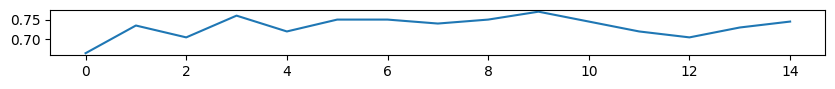

In [12]:
gnet, acc = train_model(gnet, loss_fn, optimizer, scheduler, num_epochs=15, effnet=False)

#Downloading best retrained models in terms of accuracy (> 0.8) and combining them together



In [10]:

gnet2 = models.googlenet(pretrained=True)

gnet2.fc = nn.Sequential(
    nn.Linear(1024, 1, bias=True),
    nn.Sigmoid()
)
gnet2.load_state_dict(
    torch.load('/content/drive/MyDrive/google_net_0.845_on20epoch_adam(0.0001), batch_size = 16 Imagenet.pth'))

gnet2 = gnet2.to(device)

class_correct = [0, 0]
class_total = [0, 0]
classes = ['Real', 'Fake']
gnet2.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)

        if len(labels) == 2:
            continue
        y_pred = gnet2(images)

        predicted = torch.squeeze(torch.round(y_pred))
        # print(predicted)
        # print(labels)
        c = predicted.cpu().detach() == labels

        #print(labels)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(class_correct, class_total)
print(sum(class_correct) / sum(class_total))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 86.2MB/s]


[88, 81] [100, 100]
0.845


In [9]:
resnet = models.resnet34(pretrained=True)
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1),
    nn.Sigmoid()
)

resnet.load_state_dict(
    torch.load('/content/drive/MyDrive/resnet34_0.81_on20epoch_adam(0.0001), batch_size = 16 Imagenet.pth'))

resnet = resnet.to(device)

class_correct = [0, 0]
class_total = [0, 0]
classes = ['Real', 'Fake']
resnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)

        if len(labels) == 2:
            continue
        y_pred = resnet(images)

        predicted = torch.squeeze(torch.round(y_pred))
        # print(predicted)
        # print(labels)
        c = predicted.cpu().detach() == labels

        #print(labels)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(class_correct, class_total)
print(sum(class_correct) / sum(class_total))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 192MB/s]


[75, 87] [100, 100]
0.81


In [11]:

effnet = models.efficientnet_b1(pretrained=True)

effnet.classifier[1] = nn.Sequential(
    nn.Linear(1280, 1),
    nn.Sigmoid()
)
effnet.load_state_dict(
    torch.load('/content/drive/MyDrive/effnet_0.88_on20epoch_adam(0.0001), batch_size = 16 Imagenet.pth'))

effnet = effnet.to(device)

class_correct = [0, 0]
class_total = [0, 0]
classes = ['Real', 'Fake']
effnet.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)

        if len(labels) == 2:
            continue
        y_pred = effnet(images)

        predicted = torch.squeeze(torch.round(y_pred))
        # print(predicted)
        # print(labels)
        c = predicted.cpu().detach() == labels

        #print(labels)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(class_correct, class_total)
print(sum(class_correct) / sum(class_total))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 187MB/s]


[83, 93] [100, 100]
0.88


In [45]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Remove last layer

    def forward(self, x):
        x = self.features(x)
        return x


class CombinedModel(nn.Module):
    def __init__(self, feature_dim):
        super(CombinedModel, self).__init__()
        # feature_dim is the total dimension of concatenated features
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Assuming x is the concatenated features
        x = self.classifier(x)
        return x

In [12]:
def train_model(model, loss_fn, optimizer, scheduler=None, num_epochs=10, effnet=False):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(10, 1, 1)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    acc = []

    for epoch in tqdm_notebook(range(num_epochs)):

        if scheduler is not None:
            scheduler.step()
        running_loss = 0.0
        model.train()

        for i, batch in enumerate(tqdm_notebook(trainloader)):

            X_batch, y_batch = batch
            y_batch = y_batch.float()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch.unsqueeze(1))

            if not effnet:
                loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 25 == 24:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 25))
                #losses.append(running_loss / 50)
                running_loss = 0.0

        class_correct = [0, 0]
        class_total = [0, 0]
        classes = ['Real', 'Fake']
        model.eval()

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.to(device)

                y_pred = model(images)

                predicted = torch.squeeze(torch.round(y_pred))

                c = predicted.cpu().detach() == labels

                for i in range(len(labels)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        # for i in range(2):
        #     print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))
        # print(class_total)
        # print(class_correct)
        print('Total Accuracy is: ', sum(class_correct) / sum(class_total))
        accuracy = sum(class_correct) / sum(class_total)
        acc.append(sum(class_correct) / sum(class_total))
        if accuracy > best_acc and accuracy > 0.72:
            best_acc = accuracy
            best_model_wts = model.state_dict()
            print("New Best Score!!! ")
            torch.save(model.state_dict(),
                       'own_' + str(accuracy) + '_on20epoch_adam(0.0001), batch_size = 16 Imagenet.pth')

    model.load_state_dict(best_model_wts)
    ax.plot(np.arange(len(acc)), acc)
    plt.show()
    return model, acc




In [ ]:
# Define feature extractors
extractor1 = FeatureExtractor(effnet)
extractor2 = FeatureExtractor(gnet2)
extractor3 = FeatureExtractor(resnet)

# Combined model

feature_dim = 1024 * 1280 * 1024
combined_model = CombinedModel(feature_dim)  # Set the correct feature_dim
combined_model.eval()
loss_fn = torch.nn.BCEWithLogitsLoss()

# Example training loop
for images, labels in trainloader:
    features1 = extractor1(images)
    features2 = extractor2(images)
    features3 = extractor3(images)

    # Flatten and concatenate features
    combined_features = torch.cat((features1.flatten(1), features2.flatten(1), features3.flatten(1)), dim=1)
    print(combined_features)

    # Forward pass through the combined model
    predictions = combined_model(combined_features)

    # Compute loss, backpropagate, and update
    loss = loss_fn(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [13]:

model1 = gnet2  #best for fake
model2 = resnet
model3 = effnet  #best for real (close to 1)

weights = [0.5, 0, 0.5]

model1.eval()
model2.eval()
model3.eval()

class_correct = [0, 0]
class_total = [0, 0]
classes = ['Fake', 'Real']

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)

        y_pred1 = model1(images)
        y_pred2 = model2(images)
        y_pred3 = model3(images)

        # y_pred = torch.empty(len(y_pred1))
        # for i in range(len(y_pred1)):       #85%
        #    if y_pred1[i] < (1 - y_pred3[i]):
        #       y_pred[i] = y_pred1[i]
        #    else:
        #       y_pred[i] = y_pred3[i]

        #y_pred = weights[0] * y_pred1 + weights[1] * y_pred2 + weights[2] * y_pred3     #89%

        y_pred = torch.empty(len(y_pred1))
        for i in range(len(y_pred1)):
            if y_pred3[i] > 0.5:
                y_pred[i] = y_pred3[i]
            elif y_pred1[i] < 0.5:
                y_pred[i] = y_pred1[i]
            else:
                y_pred = weights[0] * y_pred1 + weights[1] * y_pred2 + weights[2] * y_pred3

        predicted = torch.squeeze(torch.round(y_pred))

        c = predicted.cpu().detach() == labels

        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))
print(class_total)
print(class_correct)
print('Total Accuracy is: ', sum(class_correct) / sum(class_total))




Accuracy of  Fake : 83 %
Accuracy of  Real : 93 %
[100, 100]
[83, 93]
Total Accuracy is:  0.88


In [ ]:
#check for what inputs have different results, check the intersection of snawers

In [27]:
loss_fn = nn.BCEWithLogitsLoss()
teacher_model = gnet2
student_model = ConvNet()

teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

student_model.train()
teacher_model.eval()


def distillation_loss(student_output, teacher_output, T=2.0):
    teacher_probs = torch.sigmoid(teacher_output / T)
    student_probs = torch.sigmoid(student_output / T)
    return nn.functional.mse_loss(student_probs, teacher_probs)


optimizer = optim.Adam(student_model.parameters(), lr=0.001)

In [29]:

for epoch in tqdm_notebook(range(10)):
    student_model.train()
    running_loss = 0
    for i, (images, labels) in enumerate(tqdm_notebook(trainloader)):
        images, labels = images.to(device), labels.to(device)
        labels = labels.float()

        with torch.no_grad():
            teacher_output = teacher_model(images)

        student_output = student_model(images)

        true_loss = loss_fn(student_output, labels.unsqueeze(1))

        distill_loss = distillation_loss(student_output, teacher_output)

        loss = 0.25 * true_loss + 0.75 * distill_loss
        running_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 25 == 24:
            #print('On step: ', i, 'current loss: ', round(running_loss / 25, 2))
            #print(f'On step {i} current loss: {(running_loss / 25):.2f}')
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 25))
            running_loss = 0

    class_correct = [0, 0]
    class_total = [0, 0]
    classes = ['Real', 'Fake']
    student_model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)

            y_pred = student_model(images)

            predicted = torch.squeeze(torch.round(y_pred))
            # print(predicted)
            # print(labels)
            c = predicted.cpu().detach() == labels

            #print(labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(class_correct, class_total)
    print(sum(class_correct) / sum(class_total))


<ipython-input-29-a8313547f968>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-29-a8313547f968>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (images, labels) in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/116 [00:00<?, ?it/s]

[1,    25] loss: 0.192
[1,    50] loss: 0.188
[1,    75] loss: 0.188
[1,   100] loss: 0.185
[52, 53] [100, 100]
0.525


  0%|          | 0/116 [00:00<?, ?it/s]

[2,    25] loss: 0.184
[2,    50] loss: 0.187
[2,    75] loss: 0.189
[2,   100] loss: 0.183
[73, 30] [100, 100]
0.515


  0%|          | 0/116 [00:00<?, ?it/s]

[3,    25] loss: 0.186
[3,    50] loss: 0.182
[3,    75] loss: 0.187
[3,   100] loss: 0.183
[39, 62] [100, 100]
0.505


  0%|          | 0/116 [00:00<?, ?it/s]

[4,    25] loss: 0.178
[4,    50] loss: 0.194
[4,    75] loss: 0.193
[4,   100] loss: 0.196
[45, 57] [100, 100]
0.51


  0%|          | 0/116 [00:00<?, ?it/s]

[5,    25] loss: 0.196
[5,    50] loss: 0.188
[5,    75] loss: 0.185
[5,   100] loss: 0.181
[72, 31] [100, 100]
0.515


  0%|          | 0/116 [00:00<?, ?it/s]

[6,    25] loss: 0.187
[6,    50] loss: 0.181
[6,    75] loss: 0.179
[6,   100] loss: 0.184
[42, 58] [100, 100]
0.5


  0%|          | 0/116 [00:00<?, ?it/s]

[7,    25] loss: 0.185
[7,    50] loss: 0.182
[7,    75] loss: 0.180
[7,   100] loss: 0.180
[72, 30] [100, 100]
0.51


  0%|          | 0/116 [00:00<?, ?it/s]

[8,    25] loss: 0.183
[8,    50] loss: 0.183
[8,    75] loss: 0.181
[8,   100] loss: 0.182
[85, 15] [100, 100]
0.5


  0%|          | 0/116 [00:00<?, ?it/s]

[9,    25] loss: 0.178
[9,    50] loss: 0.179
[9,    75] loss: 0.178
[9,   100] loss: 0.178
[82, 19] [100, 100]
0.505


  0%|          | 0/116 [00:00<?, ?it/s]

[10,    25] loss: 0.180
[10,    50] loss: 0.179
[10,    75] loss: 0.181
[10,   100] loss: 0.180
[86, 20] [100, 100]
0.53
